# 📊 Challenge TelecomX - ETL y Análisis Exploratorio de Datos

## Objetivo
Recopilar, procesar y analizar datos de clientes de TelecomX para identificar patrones de churn (evasión de clientes) y proporcionar insights estratégicos para reducir la pérdida de clientes.

## Contenido
1. **Extracción de Datos** - Importación desde API JSON
2. **Transformación** - Limpieza y preparación de datos
3. **Carga** - Consolidación en DataFrame estructurado
4. **Análisis Exploratorio** - Identificación de patrones y tendencias
5. **Insights y Recomendaciones** - Conclusiones estratégicas

## 📖 Diccionario de Datos

Para entender mejor las variables del dataset, consulta el archivo **[Diccionario_TelecomX.md](Diccionario_TelecomX.md)** que contiene la descripción detallada de cada columna.

**Nota importante**: Los nombres de las columnas se mantienen en inglés para consistencia con el diccionario de datos proporcionado y facilitar la referencia cruzada durante el análisis.

## 📦 1. Importación de Bibliotecas

Importamos las bibliotecas necesarias para el proceso ETL y análisis exploratorio.

In [1]:
# ==============================
# CONFIGURACIÓN GLOBAL
# ==============================

# Ignorar warnings irrelevantes
import warnings
#warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# ==============================
# BIBLIOTECAS PARA MANEJO DE DATOS
# ==============================

import requests
import pandas as pd
import numpy as np
import json
import os

# ==============================
# BIBLIOTECAS PARA VISUALIZACIÓN
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# CONFIGURACIÓN DE VISUALIZACIONES
# ==============================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Si trabajas en Jupyter, puedes activar esto:
# %matplotlib inline

# ==============================
# CONFIGURACIÓN DE PANDAS
# ==============================

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ==============================
# PALETA DE COLORES PERSONALIZADA
# ==============================

color_no_churn = '#2C3E50'  # Azul oscuro elegante
color_churn = '#E74C3C'     # Rojo elegante

color_palette = [
    '#2C3E50',  # Azul oscuro
    '#E74C3C',  # Rojo elegante
    '#3498DB',  # Azul medio
    '#95A5A6',  # Gris claro
    '#34495E',  # Azul grisáceo
    '#E67E22'   # Naranja elegante
]

sns.set_palette(color_palette)

# ==============================
# CREAR CARPETA PARA IMÁGENES
# ==============================

os.makedirs('imgs', exist_ok=True)

print('✅ Bibliotecas importadas y entorno configurado correctamente')


✅ Bibliotecas importadas y entorno configurado correctamente


## 2. EXTRACCIÓN - Obtención de Datos desde API

Extraemos los datos de clientes desde la API JSON de TelecomX, verificamos que la solicitud sea exitosa y almacenamos los datos en un DataFrame para iniciar el proceso de transformación y análisis. Los datos están estructurados de forma anidada con información organizada en categorías.

In [2]:
# URL de la API con datos de TelecomX 
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json'

# Realizar petición GET a la API
response = requests.get(url)

# Verificar que la petición fue exitosa
if response.status_code == 200:
    print(f'✅ Conexión exitosa a la API (Status: {response.status_code})')
    data = response.json()
    print(f'Total de registros obtenidos: {len(data)}')
else:
    print(f'Error en la conexión (Status: {response.status_code})')

# Crear DataFrame inicial
df_raw = pd.DataFrame(data)
print(f'\n Columnas iniciales: {list(df_raw.columns)}')
df_raw.head(3)




✅ Conexión exitosa a la API (Status: 200)
Total de registros obtenidos: 7267

 Columnas iniciales: ['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


**Hallazgo clave:** 

En este punto el dataFrame df_raw no es usable directamente para EDA. Las columnas customer, phone, internet, account contienen diccionarios, por lo que es necesario normalizar.


## 3. TRANSFORMACIÓN - Desanidación de Datos JSON

Los datos vienen en formato anidado (diccionarios dentro de columnas). Necesitamos desanidarlos para crear un DataFrame plano y estructurado.

In [3]:
# Primeros pasos
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


**Hallazgo clave:** Dado que los datos provienen de una API en formato JSON anidado, se utilizará `pd.json_normalize()` para convertir la estructura jerárquica en un DataFrame plano, facilitando el análisis exploratorio. Además se procede a desanidar cada una de las columnas anidadas para obtener un DataFrame con todas las variables.

In [4]:
# Función para desanidar columnas con diccionarios

def desanidar_columna(df, columna_nombre):
    """
    Desanida una columna que contiene diccionarios y la convierte en columnas separadas.
    
    Args:
        df: DataFrame original
        columna_nombre: Nombre de la columna a desanidar
    
    Returns:
        DataFrame con las columnas desanidadas
    """
    # Convertir la columna de diccionarios a DataFrame
    df_expandido = pd.json_normalize(df[columna_nombre])
    
    return df_expandido

# Desanidar cada categoría de datos
print('Desanidando datos...')

# 1. Datos del cliente (customer)
df_customer = desanidar_columna(df_raw, 'customer')
print(f'  ✓ Customer: {len(df_customer.columns)} columnas')

# 2. Datos de teléfono (phone)
df_phone = desanidar_columna(df_raw, 'phone')
print(f'  ✓ Phone: {len(df_phone.columns)} columnas')

# 3. Datos de internet (internet)
df_internet = desanidar_columna(df_raw, 'internet')
print(f'  ✓ Internet: {len(df_internet.columns)} columnas')

# 4. Datos de cuenta (account)
df_account = desanidar_columna(df_raw, 'account')
print(f'  ✓ Account: {len(df_account.columns)} columnas')

# Consolidar todos los datos en un único DataFrame
df = pd.concat([
    df_raw[['customerID', 'Churn']],  # Columnas base
    df_customer,
    df_phone,
    df_internet,
    df_account
], axis=1)


print(f'\n✅ Transformación completada')
print(f'DataFrame final: {df.shape[0]} filas x {df.shape[1]} columnas')
print(f'\nColumnas finales:\n{list(df.columns)}')

Desanidando datos...
  ✓ Customer: 5 columnas
  ✓ Phone: 2 columnas
  ✓ Internet: 7 columnas
  ✓ Account: 5 columnas

✅ Transformación completada
DataFrame final: 7267 filas x 21 columnas

Columnas finales:
['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


### Análisis de la Estructura de los Datos

Los datos fueron obtenidos desde una API en formato JSON con estructura jerárquica
(diccionarios anidados). Posteriormente, se realizó un proceso de normalización
para convertirlos en un DataFrame plano de 21 columnas.

### 1. Identificación del Cliente
- `customerID`: Identificador único del cliente.
- `Churn`: Indica si el cliente canceló el servicio (`Yes` o `No`).

### 2. Información del Cliente
- `gender`: Género del cliente (`Male` o `Female`).
- `SeniorCitizen`: Indica si el cliente es persona mayor (0 = No, 1 = Sí).
- `Partner`: Si el cliente tiene pareja.
- `Dependents`: Si el cliente tiene dependientes.
- `tenure`: Tiempo de permanencia como cliente (en meses).

### 3. Servicios de Telefonía
- `PhoneService`: Indica si posee servicio de teléfono (`Yes` o `No`).
- `MultipleLines`: Si posee múltiples líneas telefónicas.

### 4. Servicios de Internet
- `InternetService`: Tipo de servicio contratado (`DSL`, `Fiber optic`, `No`).
- `OnlineSecurity`: Servicio de seguridad en línea.
- `OnlineBackup`: Servicio de respaldo en línea.
- `DeviceProtection`: Protección de dispositivos.
- `TechSupport`: Soporte técnico.
- `StreamingTV`: Servicio de televisión en streaming.
- `StreamingMovies`: Servicio de películas en streaming.

### 5. Información de la Cuenta
- `Contract`: Tipo de contrato (`Month-to-month`, `One year`, `Two year`).
- `PaperlessBilling`: Facturación electrónica.
- `PaymentMethod`: Método de pago.
- `Charges.Monthly`: Cargo mensual.
- `Charges.Total`: Total pagado por el cliente.


In [6]:
#Verificamos valores duplicados
print("Numero de duplicados", df.duplicated().sum())

Numero de duplicados 0


In [7]:
#Verificamos valores nulos
print("Numero de Nulos \n", df.isnull().sum())

Numero de Nulos 
 customerID          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges.Monthly     0
Charges.Total       0
dtype: int64


In [8]:
#Verificamos valores vacíos o en blanco:
df.apply(lambda x: x.astype(str).str.strip() == '').sum()

customerID            0
Churn               224
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
Charges.Monthly       0
Charges.Total        11
dtype: int64

In [9]:
#Verificamos valores únicos
for col in df.columns:
    print(f"\n✓ Columna: {col}")
    print(df[col].unique())



✓ Columna: customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

✓ Columna: Churn
['No' 'Yes' '']

✓ Columna: gender
['Female' 'Male']

✓ Columna: SeniorCitizen
[0 1]

✓ Columna: Partner
['Yes' 'No']

✓ Columna: Dependents
['Yes' 'No']

✓ Columna: tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]

✓ Columna: PhoneService
['Yes' 'No']

✓ Columna: MultipleLines
['No' 'Yes' 'No phone service']

✓ Columna: InternetService
['DSL' 'Fiber optic' 'No']

✓ Columna: OnlineSecurity
['No' 'Yes' 'No internet service']

✓ Columna: OnlineBackup
['Yes' 'No' 'No internet service']

✓ Columna: DeviceProtection
['No' 'Yes' 'No internet service']

✓ Columna: TechSupport
['Yes' 'No' 'No internet service']

✓ Columna: StreamingTV
['Yes' 'No' 'No internet service']

✓ Columna: StreamingM

**Hallazgo clave:** 
Se verifica que columna churn tiene valores vacío y columna Charges.Total son de tipo string, 

In [11]:
# Contar valores vacíos en Churn
print("Valores vacíos en Churn:", (df['Churn'] == "").sum())

Valores vacíos en Churn: 224


In [12]:
df['Charges.Total'].unique()[:10]


array(['593.3', '542.4', '280.85', '1237.85', '267.4', '571.45',
       '7904.25', '5377.8', '340.35', '5957.9'], dtype=object)

In [13]:
# Convertir Charges.Total a numérico
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

# Verificar si se generaron nulos
print("Valores nulos en Charges.Total:", df['Charges.Total'].isna().sum())


Valores nulos en Charges.Total: 11


In [30]:
# Eliminamos valores nulos que se generaron al convertir Charges,Total
df = df.dropna(subset=['Charges.Total'])

In [31]:
# Eliminar registros con Churn vacío
df = df[df['Churn'] != ""]

In [15]:
print("Valores nulos en Charges.Total:", (df['Charges.Total'] == "").sum())

print("Valores vacíos en Churn:", (df['Churn'] == "").sum())

Valores nulos en Charges.Total: 0
Valores vacíos en Churn: 0


In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

### Limpieza de la Variable Objetivo (Churn)

- Se identificaron posibles valores vacíos en la variable `Churn`, la cual representa
la cancelación del servicio por parte del cliente.

- Dado que `Churn` es la variable objetivo para el análisis y futuros modelos
predictivos, los registros sin esta información no aportan valor analítico
y podrían generar sesgos en los resultados.

- Por esta razón, se eliminaron los registros con valores vacíos en `Churn`
para garantizar la calidad y consistencia del análisis.


In [17]:
# Visualizar primeras filas del DataFrame transformado
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

## 📋 4. CARGA - Información General del Dataset

Exploramos la estructura, tipos de datos y calidad del dataset transformado.

In [18]:
# Información general del dataset
print('='*60)
print('INFORMACIÓN GENERAL DEL DATASET')
print('='*60)
print(f'\n📊 Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas')
print(f'💾 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print('\n' + '='*60)
df.info()

INFORMACIÓN GENERAL DEL DATASET

📊 Dimensiones: 7,043 filas x 21 columnas
💾 Memoria utilizada: 6.56 MB

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   obj

## 🧹 5. LIMPIEZA - Análisis de Calidad de Datos

Identificamos valores nulos, duplicados y problemas de calidad en los datos.

In [19]:
# Análisis de valores nulos
print('='*60)
print('ANÁLISIS DE VALORES NULOS')
print('='*60)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Columna': missing.index,
    'Valores Nulos': missing.values,
    'Porcentaje (%)': missing_pct.values
}).sort_values('Valores Nulos', ascending=False)

# Mostrar solo columnas con valores nulos
missing_df_filtered = missing_df[missing_df['Valores Nulos'] > 0]

if len(missing_df_filtered) > 0:
    print(f'\n⚠️  Se encontraron {len(missing_df_filtered)} columnas con valores nulos:\n')
    print(missing_df_filtered.to_string(index=False))
else:
    print('\n✅ No se encontraron valores nulos en el dataset')

# Verificar duplicados
duplicados = df.duplicated().sum()
print(f'\n📋 Registros duplicados: {duplicados}')

if duplicados > 0:
    print(f'⚠️  Se encontraron {duplicados} registros duplicados')
else:
    print('✅ No se encontraron registros duplicados')

ANÁLISIS DE VALORES NULOS

⚠️  Se encontraron 1 columnas con valores nulos:

      Columna  Valores Nulos  Porcentaje (%)
Charges.Total             11        0.156183

📋 Registros duplicados: 0
✅ No se encontraron registros duplicados


In [20]:
# Convertir tipos de datos apropiadamente
print('🔄 Convirtiendo tipos de datos...')

# Convertir SeniorCitizen a categórico
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Convertir TotalCharges a numérico (puede tener espacios en blanco)
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

# Convertir MonthlyCharges a numérico
df['Charges.Monthly'] = pd.to_numeric(df['Charges.Monthly'], errors='coerce')

# Convertir tenure a entero
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce').astype('Int64')

print('✅ Tipos de datos convertidos correctamente')

# Manejar valores nulos en TotalCharges (si existen)
if df['Charges.Total'].isnull().sum() > 0:
    print(f'\n⚠️  Valores nulos en TotalCharges: {df["Charges.Total"].isnull().sum()}')
    # Imputar con 0 para clientes nuevos (tenure = 0)
    df['Charges.Total'].fillna(0, inplace=True)
    print('✅ Valores nulos imputados con 0')

print('\n✅ Limpieza de datos completada')

🔄 Convirtiendo tipos de datos...
✅ Tipos de datos convertidos correctamente

⚠️  Valores nulos en TotalCharges: 11
✅ Valores nulos imputados con 0

✅ Limpieza de datos completada


# 📊 ANÁLISIS EXPLORATORIO DE DATOS (EDA)

Realizamos un análisis exhaustivo para identificar patrones, tendencias y factores relacionados con el churn de clientes.

## 📈 6. Análisis Univariado - Variable Objetivo (Churn)

Analizamos la distribución de la variable objetivo para entender la proporción de clientes que abandonan el servicio.

ANÁLISIS DE CHURN

📊 Distribución de Churn:
  • No (Clientes activos): 5,174 (73.46%)
  • Yes (Clientes perdidos): 1,869 (26.54%)

⚠️  Tasa de Churn: 26.54%


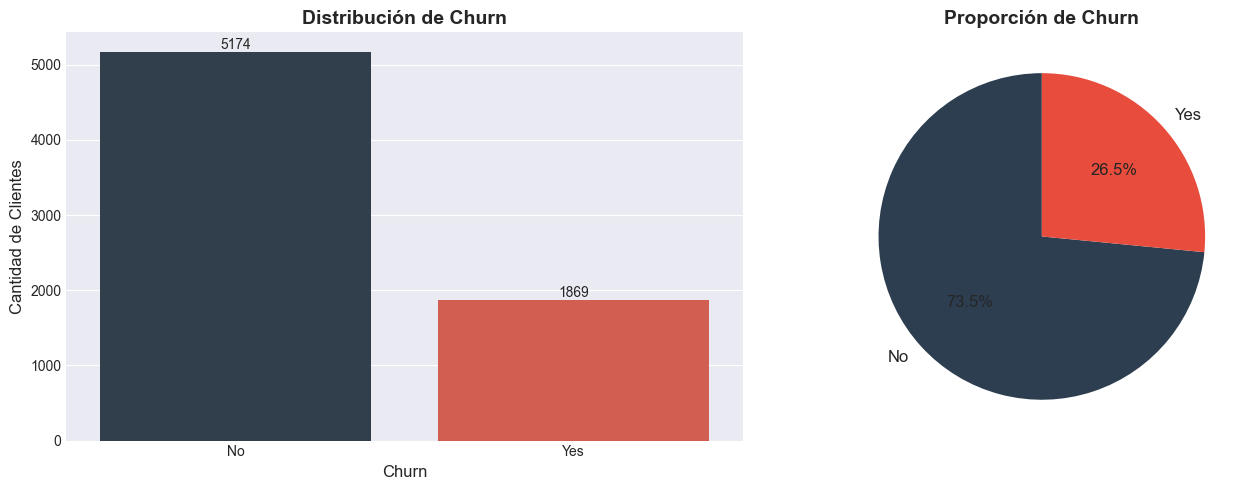

In [21]:
# Análisis de la variable Churn
print('='*60)
print('ANÁLISIS DE CHURN')
print('='*60)

churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print(f'\n📊 Distribución de Churn:')
print(f'  • No (Clientes activos): {churn_counts["No"]:,} ({churn_pct["No"]:.2f}%)')
print(f'  • Yes (Clientes perdidos): {churn_counts["Yes"]:,} ({churn_pct["Yes"]:.2f}%)')
print(f'\n⚠️  Tasa de Churn: {churn_pct["Yes"]:.2f}%')

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
sns.countplot(data=df, x='Churn', palette=['#2C3E50', '#E74C3C'], ax=axes[0])
axes[0].set_title('Distribución de Churn', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Cantidad de Clientes', fontsize=12)

# Agregar valores en las barras
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Gráfico de pastel
colors = ['#2C3E50', '#E74C3C']
axes[1].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Proporción de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('imgs/01_distribucion_churn.png', dpi=300, bbox_inches='tight')
plt.show()

## 👥 7. Análisis Demográfico

Exploramos las características demográficas de los clientes y su relación con el churn.

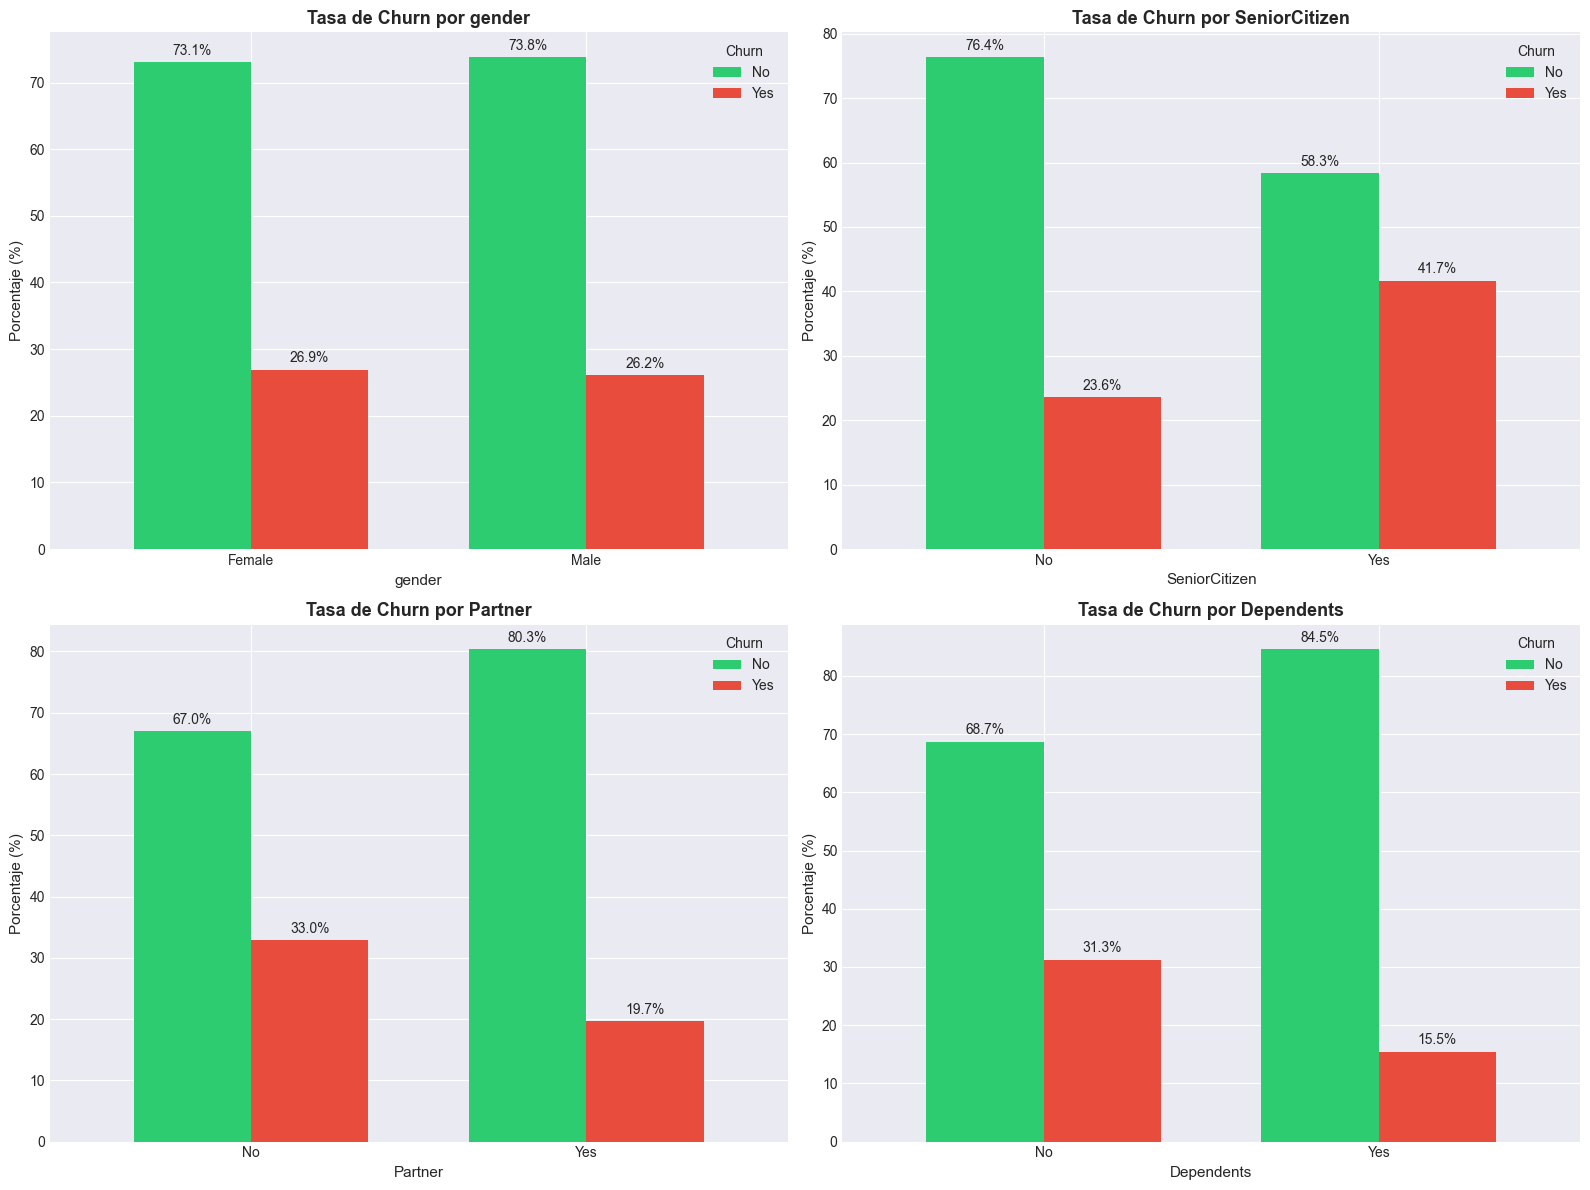

RESUMEN: CHURN POR CARACTERÍSTICAS DEMOGRÁFICAS

📊 gender:
  • Female: 26.92% de churn
  • Male: 26.16% de churn

📊 SeniorCitizen:
  • No: 23.61% de churn
  • Yes: 41.68% de churn

📊 Partner:
  • No: 32.96% de churn
  • Yes: 19.66% de churn

📊 Dependents:
  • No: 31.28% de churn
  • Yes: 15.45% de churn


In [22]:
# Variables demográficas a analizar
demographic_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, var in enumerate(demographic_vars):
    # Calcular proporciones de churn por categoría
    churn_by_var = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
    
    # Gráfico de barras agrupadas
    churn_by_var.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'], width=0.7)
    axes[idx].set_title(f'Tasa de Churn por {var}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=11)
    axes[idx].set_ylabel('Porcentaje (%)', fontsize=11)
    axes[idx].legend(title='Churn', labels=['No', 'Yes'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)
    
    # Agregar valores en las barras
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.savefig('imgs/02_analisis_demografico.png', dpi=300, bbox_inches='tight')
plt.show()

# Resumen estadístico
print('='*60)
print('RESUMEN: CHURN POR CARACTERÍSTICAS DEMOGRÁFICAS')
print('='*60)
for var in demographic_vars:
    churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
    print(f'\n📊 {var}:')
    for category, rate in churn_rate.items():
        print(f'  • {category}: {rate:.2f}% de churn')

## ⏱️ 8. Análisis de Permanencia (Tenure)

Analizamos la relación entre el tiempo de permanencia del cliente y el churn.

ANÁLISIS DE PERMANENCIA (TENURE)

📊 Estadísticas generales de Tenure (meses):
count       7043.0
mean     32.371149
std      24.559481
min            0.0
25%            9.0
50%           29.0
75%           55.0
max           72.0
Name: tenure, dtype: Float64

📊 Tenure promedio por Churn:
            mean  median        std
Churn                              
No     37.569965    38.0  24.113777
Yes    17.979133    10.0  19.531123


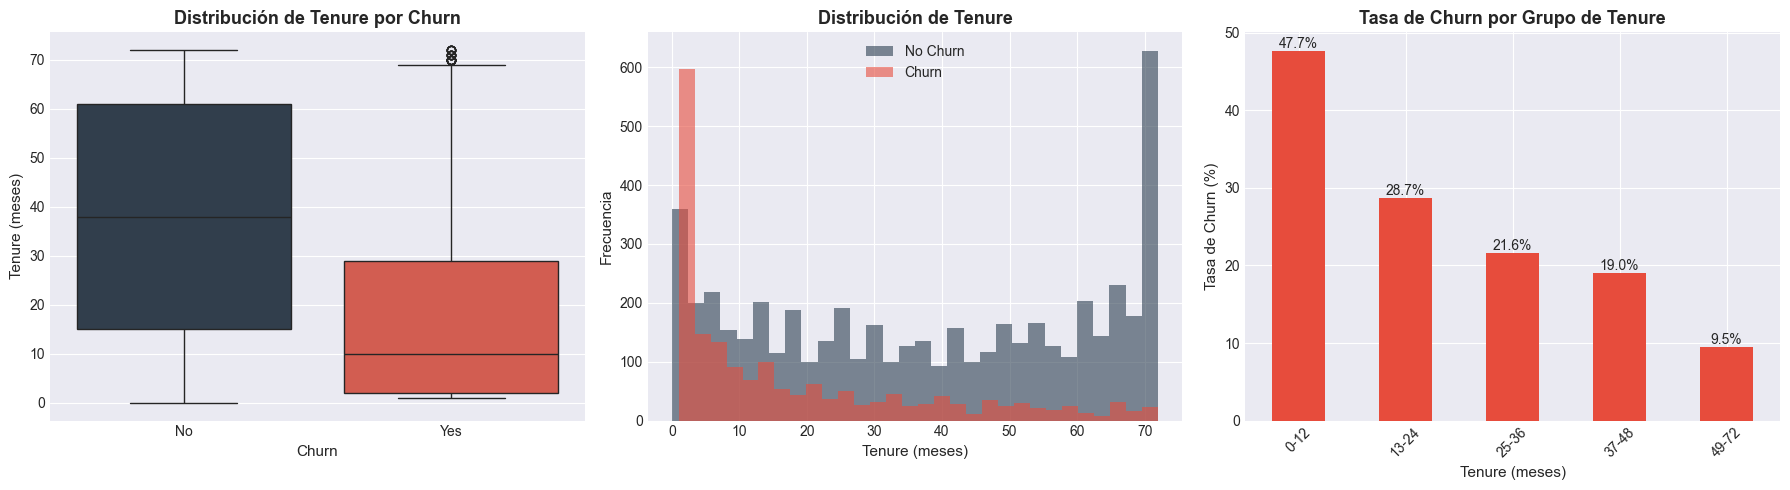

In [23]:
# Estadísticas descriptivas de tenure
print('='*60)
print('ANÁLISIS DE PERMANENCIA (TENURE)')
print('='*60)
print(f'\n📊 Estadísticas generales de Tenure (meses):')
print(df['tenure'].describe())

print(f'\n📊 Tenure promedio por Churn:')
tenure_by_churn = df.groupby('Churn')['tenure'].agg(['mean', 'median', 'std'])
print(tenure_by_churn)

# Visualizaciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribución de tenure por churn (boxplot)
sns.boxplot(data=df, x='Churn', y='tenure', palette=['#2C3E50', '#E74C3C'], ax=axes[0])
axes[0].set_title('Distribución de Tenure por Churn', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=11)
axes[0].set_ylabel('Tenure (meses)', fontsize=11)

# 2. Histograma de tenure por churn
df[df['Churn'] == 'No']['tenure'].hist(bins=30, alpha=0.6, label='No Churn', 
                                         color='#2C3E50', ax=axes[1])
df[df['Churn'] == 'Yes']['tenure'].hist(bins=30, alpha=0.6, label='Churn', 
                                          color='#E74C3C', ax=axes[1])
axes[1].set_title('Distribución de Tenure', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Tenure (meses)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].legend()

# 3. Tasa de churn por grupos de tenure
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 72], 
                             labels=['0-12', '13-24', '25-36', '37-48', '49-72'])
churn_by_tenure_group = df.groupby('tenure_group')['Churn'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
)
churn_by_tenure_group.plot(kind='bar', color='#E74C3C', ax=axes[2])
axes[2].set_title('Tasa de Churn por Grupo de Tenure', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Tenure (meses)', fontsize=11)
axes[2].set_ylabel('Tasa de Churn (%)', fontsize=11)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

# Agregar valores en las barras
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.savefig('imgs/03_analisis_permanencia.png', dpi=300, bbox_inches='tight')
plt.show()

## 📡 9. Análisis de Servicios

Exploramos qué servicios están asociados con mayor o menor churn.

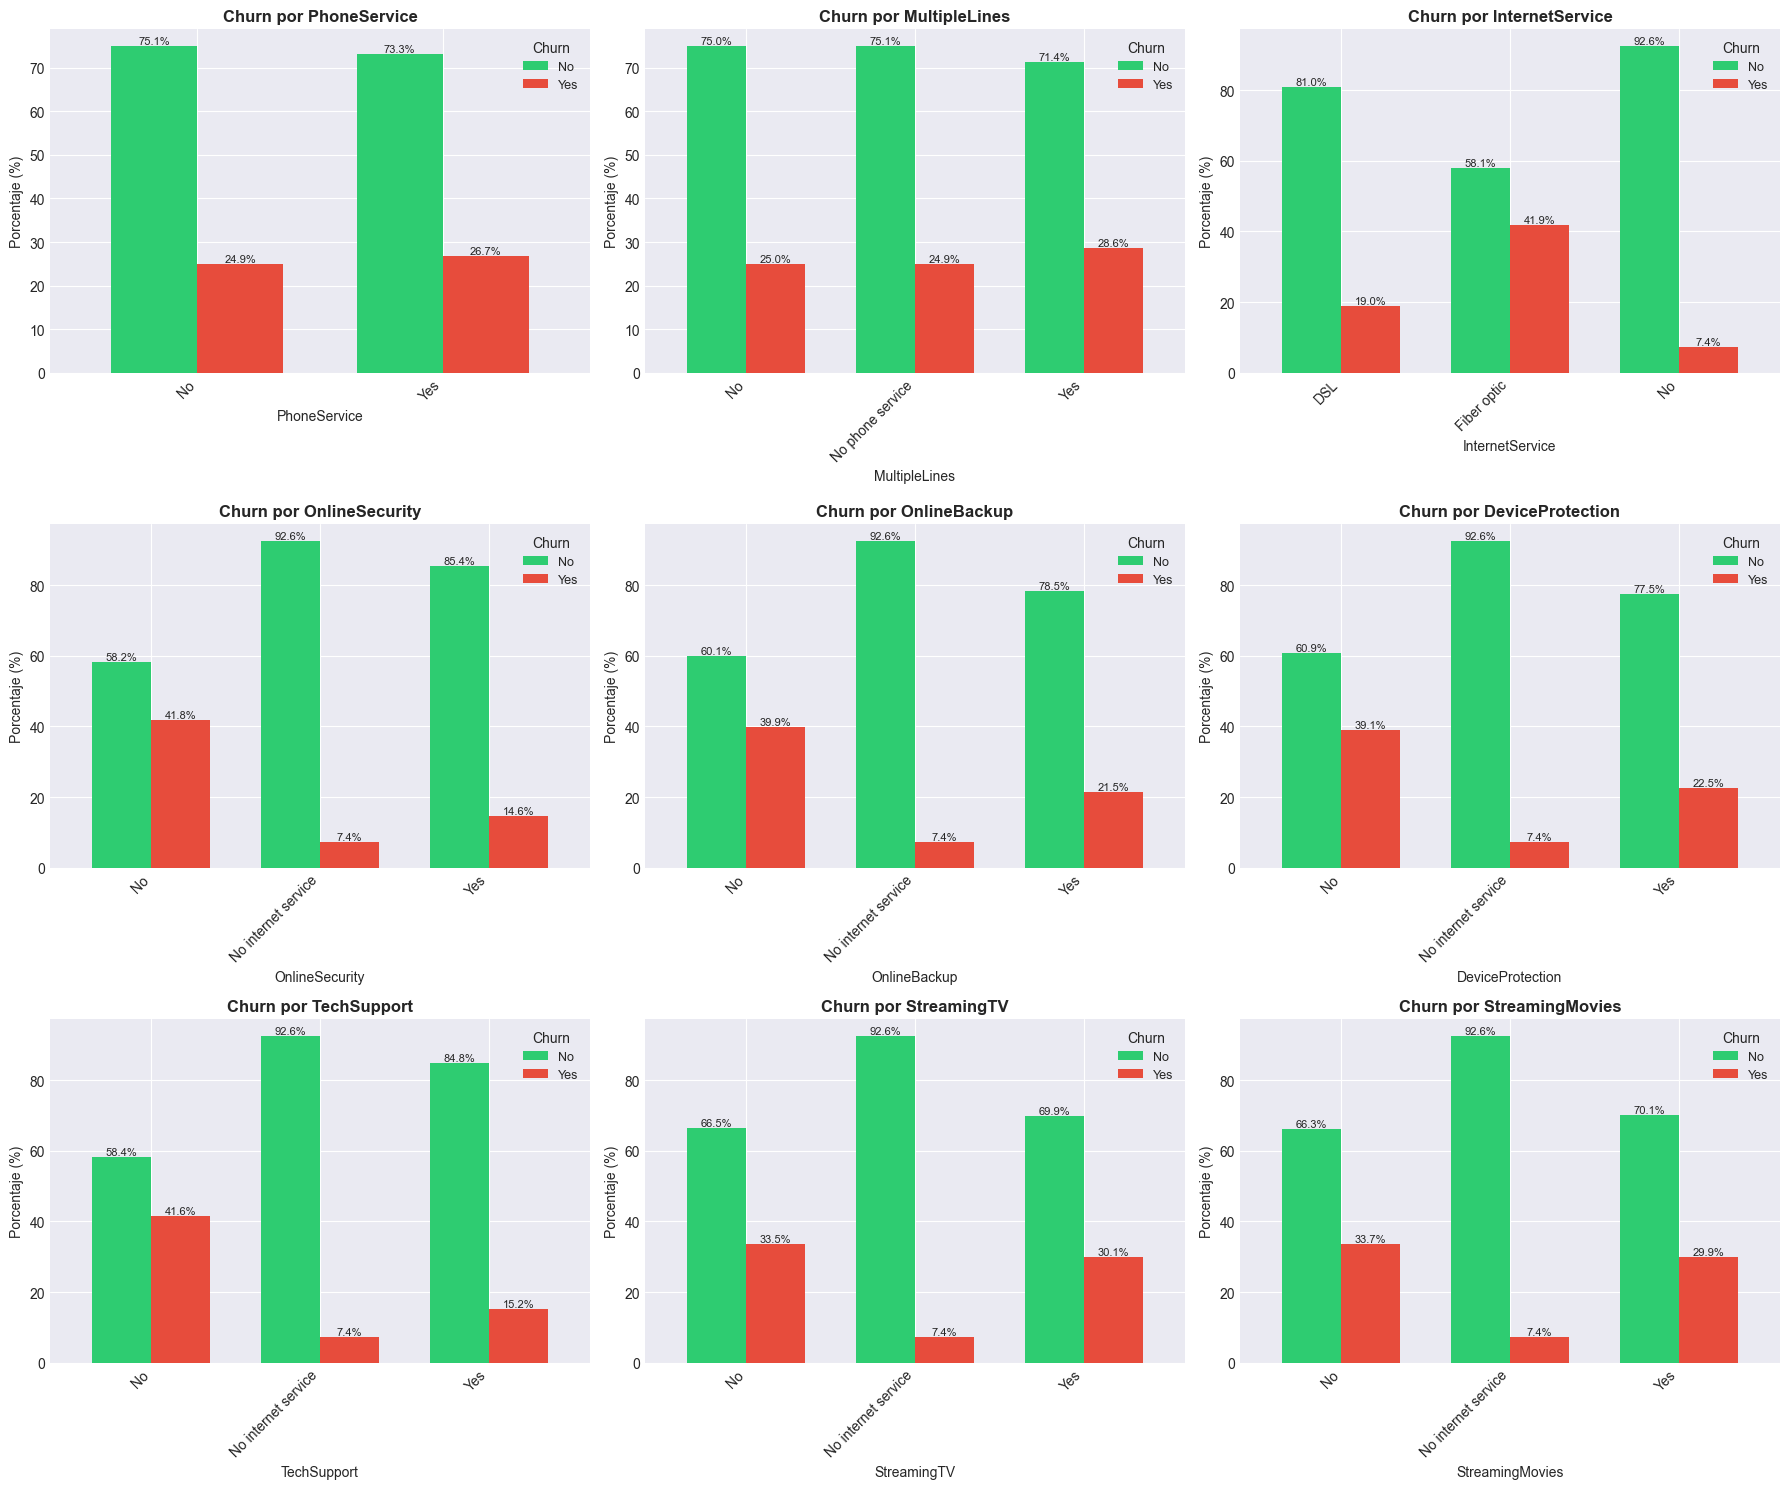

SERVICIOS CON MAYOR IMPACTO EN CHURN

📊 PhoneService:
  • No: 24.93% de churn
  • Yes: 26.71% de churn

📊 MultipleLines:
  • No: 25.04% de churn
  • No phone service: 24.93% de churn
  • Yes: 28.61% de churn

📊 InternetService:
  • DSL: 18.96% de churn
  • Fiber optic: 41.89% de churn
  • No: 7.40% de churn

📊 OnlineSecurity:
  • No: 41.77% de churn
  • No internet service: 7.40% de churn
  • Yes: 14.61% de churn

📊 OnlineBackup:
  • No: 39.93% de churn
  • No internet service: 7.40% de churn
  • Yes: 21.53% de churn

📊 DeviceProtection:
  • No: 39.13% de churn
  • No internet service: 7.40% de churn
  • Yes: 22.50% de churn

📊 TechSupport:
  • No: 41.64% de churn
  • No internet service: 7.40% de churn
  • Yes: 15.17% de churn

📊 StreamingTV:
  • No: 33.52% de churn
  • No internet service: 7.40% de churn
  • Yes: 30.07% de churn

📊 StreamingMovies:
  • No: 33.68% de churn
  • No internet service: 7.40% de churn
  • Yes: 29.94% de churn


In [24]:
# Variables de servicios
service_vars = ['PhoneService', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Calcular tasa de churn por servicio
churn_rates = {}
for var in service_vars:
    churn_rate = df.groupby(var)['Churn'].apply(
        lambda x: (x == 'Yes').sum() / len(x) * 100
    ).to_dict()
    churn_rates[var] = churn_rate

# Visualización de servicios clave
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, var in enumerate(service_vars):
    churn_by_service = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
    churn_by_service.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'], width=0.7)
    axes[idx].set_title(f'Churn por {var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel('Porcentaje (%)', fontsize=10)
    axes[idx].legend(title='Churn', labels=['No', 'Yes'], fontsize=9)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    # Agregar valores
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', fontsize=8)

plt.tight_layout()
plt.savefig('imgs/04_analisis_servicios.png', dpi=300, bbox_inches='tight')
plt.show()

# Resumen de servicios con mayor impacto en churn
print('='*60)
print('SERVICIOS CON MAYOR IMPACTO EN CHURN')
print('='*60)
for var in service_vars:
    print(f'\n📊 {var}:')
    for category, rate in churn_rates[var].items():
        print(f'  • {category}: {rate:.2f}% de churn')

## 📄 10. Análisis de Contrato y Facturación

Analizamos cómo el tipo de contrato, método de pago y facturación afectan el churn.

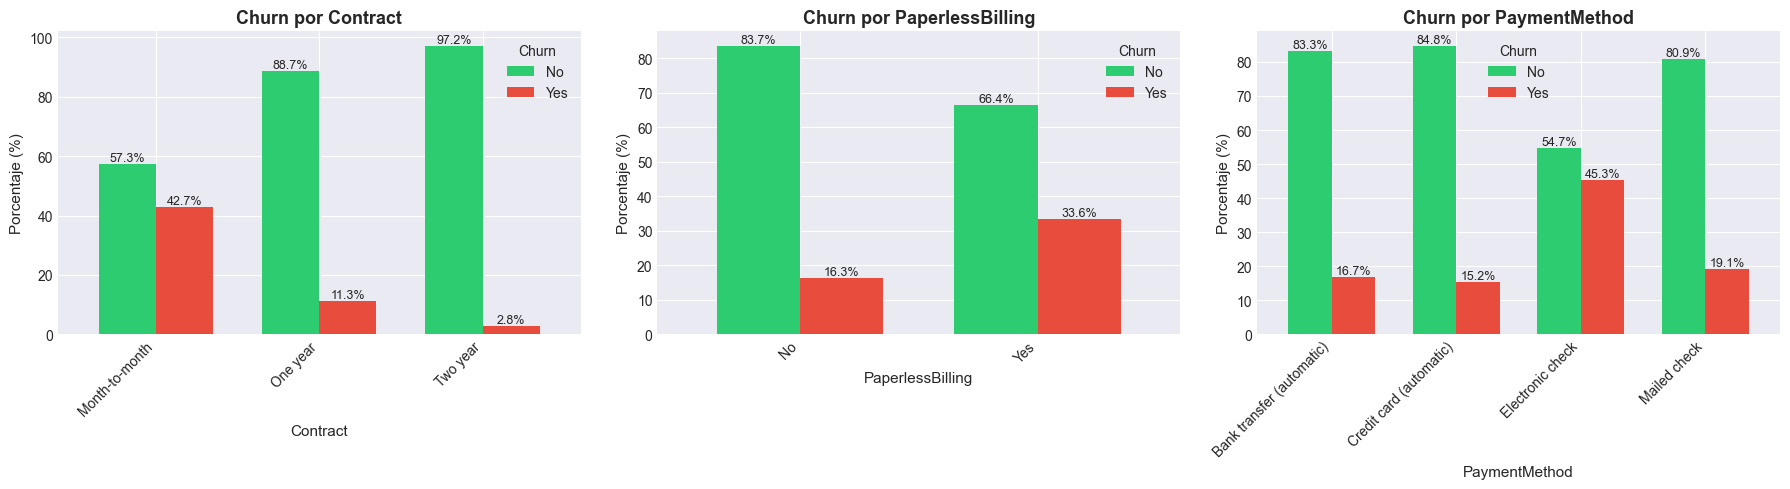

ANÁLISIS DE CONTRATO Y FACTURACIÓN

📊 Contract:
  • Month-to-month: 42.71% de churn
  • One year: 11.27% de churn
  • Two year: 2.83% de churn

📊 PaperlessBilling:
  • No: 16.33% de churn
  • Yes: 33.57% de churn

📊 PaymentMethod:
  • Bank transfer (automatic): 16.71% de churn
  • Credit card (automatic): 15.24% de churn
  • Electronic check: 45.29% de churn
  • Mailed check: 19.11% de churn


In [25]:
# Variables de cuenta
account_vars = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, var in enumerate(account_vars):
    churn_by_var = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
    churn_by_var.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'], width=0.7)
    axes[idx].set_title(f'Churn por {var}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=11)
    axes[idx].set_ylabel('Porcentaje (%)', fontsize=11)
    axes[idx].legend(title='Churn', labels=['No', 'Yes'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    # Agregar valores
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', fontsize=9)

plt.tight_layout()
plt.savefig('imgs/05_analisis_contratos.png', dpi=300, bbox_inches='tight')
plt.show()

# Resumen estadístico
print('='*60)
print('ANÁLISIS DE CONTRATO Y FACTURACIÓN')
print('='*60)
for var in account_vars:
    churn_rate = df.groupby(var)['Churn'].apply(
        lambda x: (x == 'Yes').sum() / len(x) * 100
    )
    print(f'\n📊 {var}:')
    for category, rate in churn_rate.items():
        print(f'  • {category}: {rate:.2f}% de churn')

## 💰 11. Análisis de Cargos Mensuales y Totales

Exploramos la relación entre los cargos (mensuales y totales) y el churn.

ANÁLISIS DE CARGOS

📊 Cargos Mensuales (MonthlyCharges):
        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
No     5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
Yes    1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35

📊 Cargos Totales (TotalCharges):
        count         mean          std    min    25%       50%      75%  \
Churn                                                                      
No     5174.0  2549.911442  2329.954215   0.00  572.9  1679.525  4262.85   
Yes    1869.0  1531.796094  1890.822994  18.85  134.5   703.550  2331.30   

           max  
Churn           
No     8672.45  
Yes    8684.80  


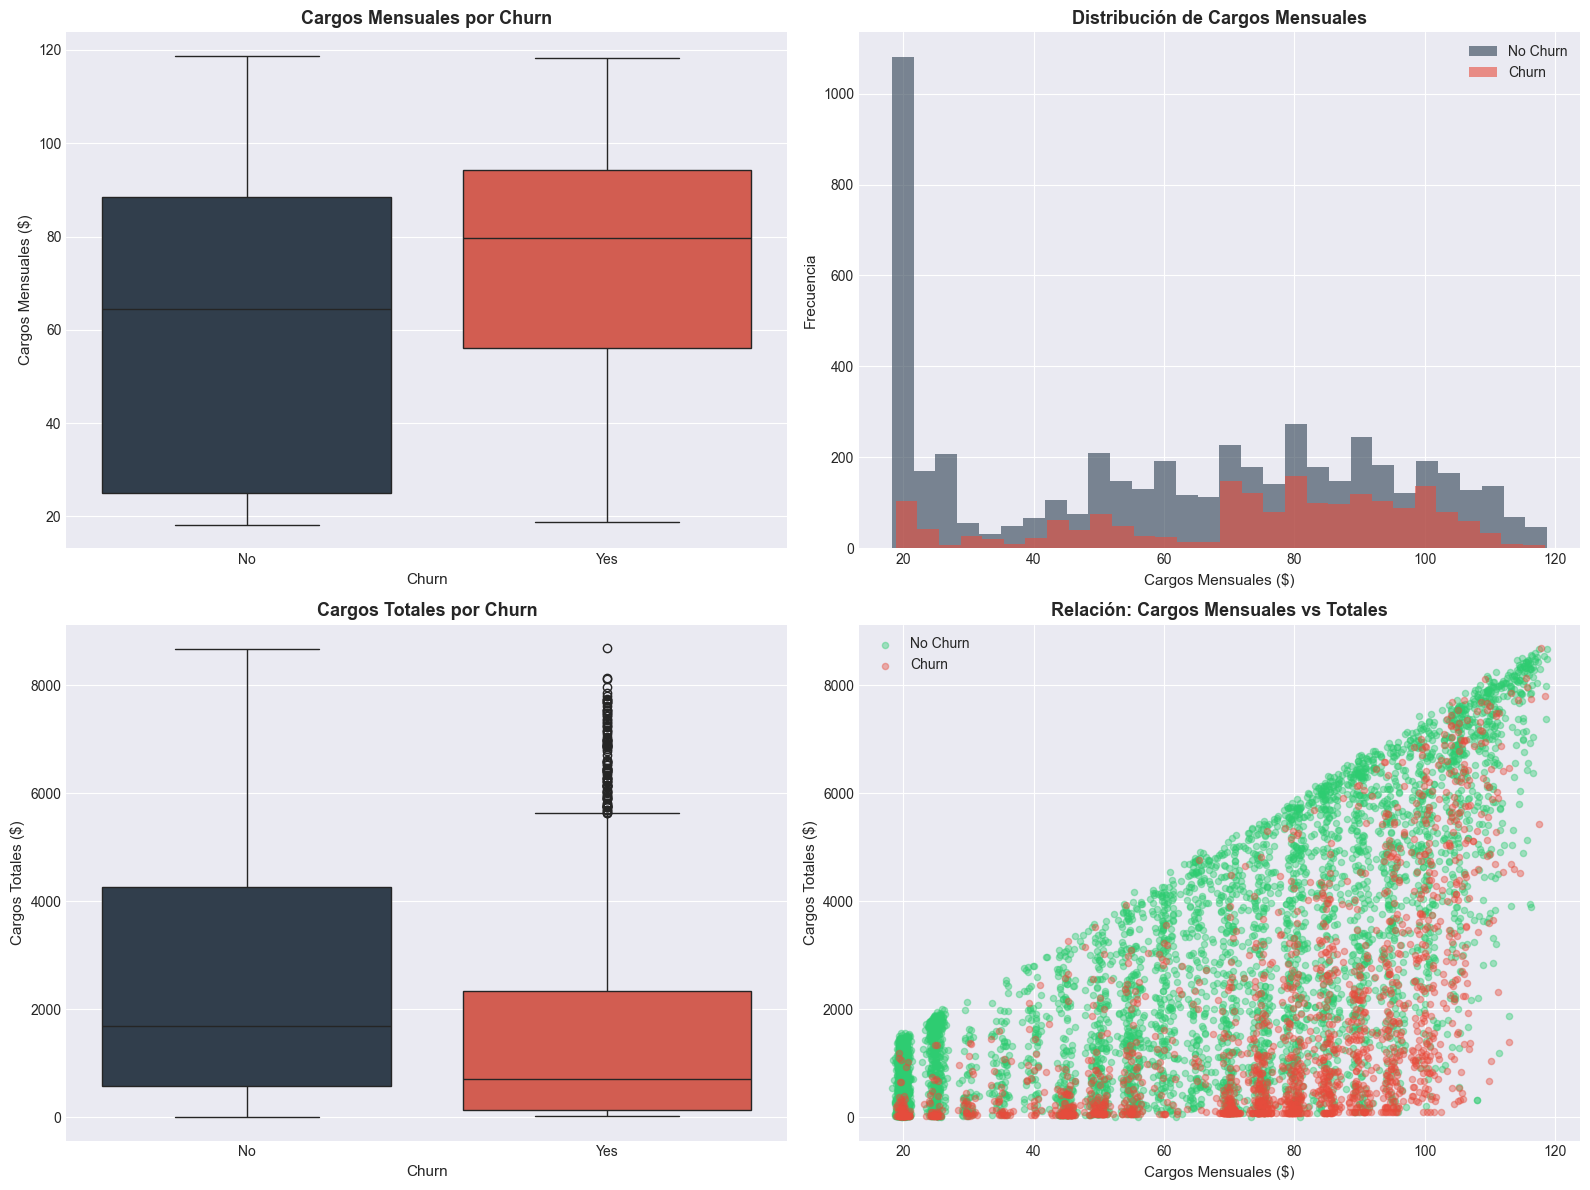

In [26]:
# Estadísticas de cargos
print('='*60)
print('ANÁLISIS DE CARGOS')
print('='*60)

print('\n📊 Cargos Mensuales (MonthlyCharges):')
print(df.groupby('Churn')['Charges.Monthly'].describe())

print('\n📊 Cargos Totales (TotalCharges):')
print(df.groupby('Churn')['Charges.Total'].describe())

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Boxplot de MonthlyCharges
sns.boxplot(data=df, x='Churn', y='Charges.Monthly', palette=['#2C3E50', '#E74C3C'], ax=axes[0, 0])
axes[0, 0].set_title('Cargos Mensuales por Churn', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Churn', fontsize=11)
axes[0, 0].set_ylabel('Cargos Mensuales ($)', fontsize=11)

# 2. Histograma de MonthlyCharges
df[df['Churn'] == 'No']['Charges.Monthly'].hist(bins=30, alpha=0.6, label='No Churn', 
                                                 color='#2C3E50', ax=axes[0, 1])
df[df['Churn'] == 'Yes']['Charges.Monthly'].hist(bins=30, alpha=0.6, label='Churn', 
                                                  color='#E74C3C', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Cargos Mensuales', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Cargos Mensuales ($)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].legend()

# 3. Boxplot de TotalCharges
sns.boxplot(data=df, x='Churn', y='Charges.Total', palette=['#2C3E50', '#E74C3C'], ax=axes[1, 0])
axes[1, 0].set_title('Cargos Totales por Churn', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Churn', fontsize=11)
axes[1, 0].set_ylabel('Cargos Totales ($)', fontsize=11)

# 4. Scatter plot: MonthlyCharges vs TotalCharges
for churn_val, color, label in [('No', '#2ecc71', 'No Churn'), ('Yes', '#e74c3c', 'Churn')]:
    data_subset = df[df['Churn'] == churn_val]
    axes[1, 1].scatter(data_subset['Charges.Monthly'], data_subset['Charges.Total'], 
                       alpha=0.4, c=color, label=label, s=20)
axes[1, 1].set_title('Relación: Cargos Mensuales vs Totales', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Cargos Mensuales ($)', fontsize=11)
axes[1, 1].set_ylabel('Cargos Totales ($)', fontsize=11)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('imgs/06_analisis_cargos.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔗 12. Matriz de Correlación

Analizamos las correlaciones entre variables numéricas para identificar relaciones importantes.

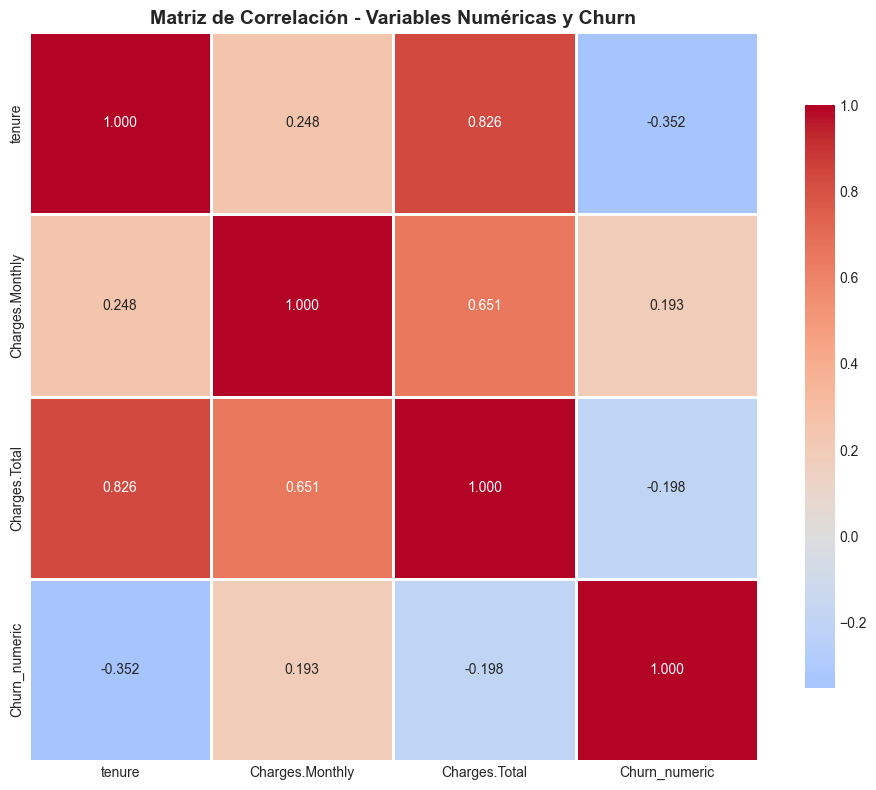

CORRELACIÓN CON CHURN

📊 Variables ordenadas por correlación con Churn:
  • Charges.Monthly: 0.1934
  • Charges.Total: -0.1983
  • tenure: -0.3522


In [27]:
# Seleccionar variables numéricas
numeric_vars = ['tenure', 'Charges.Monthly', 'Charges.Total']

# Crear variable numérica para Churn
df['Churn_numeric'] = (df['Churn'] == 'Yes').astype(int)

# Calcular matriz de correlación
correlation_vars = numeric_vars + ['Churn_numeric']
corr_matrix = df[correlation_vars].corr()

# Visualización
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8}, fmt='.3f')
plt.title('Matriz de Correlación - Variables Numéricas y Churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('imgs/07_matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar correlaciones con Churn
print('='*60)
print('CORRELACIÓN CON CHURN')
print('='*60)
churn_corr = corr_matrix['Churn_numeric'].sort_values(ascending=False)
print('\n📊 Variables ordenadas por correlación con Churn:')
for var, corr in churn_corr.items():
    if var != 'Churn_numeric':
        print(f'  • {var}: {corr:.4f}')

# 💡 13. INSIGHTS Y CONCLUSIONES ESTRATÉGICAS

## Hallazgos Clave del Análisis

### 🎯 Tasa de Churn General
- La empresa presenta una tasa de churn significativa que requiere atención inmediata
- Los clientes que abandonan representan una pérdida importante de ingresos

### 👥 Factores Demográficos
- **Adultos mayores (SeniorCitizen)**: Presentan mayor tendencia al churn
- **Clientes sin pareja o dependientes**: Mayor probabilidad de abandonar el servicio
- **Género**: No muestra diferencias significativas en la tasa de churn

### ⏱️ Permanencia (Tenure)
- **Clientes nuevos (0-12 meses)**: Grupo de MAYOR RIESGO de churn
- **Clientes de largo plazo (>24 meses)**: Significativamente más leales
- La retención en los primeros meses es CRÍTICA

### 📡 Servicios
- **Fiber optic**: Asociado con mayor churn (posiblemente por precio)
- **Servicios de seguridad y soporte**: Clientes SIN estos servicios tienen mayor churn
- **OnlineSecurity, OnlineBackup, TechSupport**: Servicios protectores contra churn

### 📄 Tipo de Contrato
- **Month-to-month**: ALTÍSIMA tasa de churn (mayor flexibilidad = menor compromiso)
- **Contratos de 1-2 años**: Tasas de churn SIGNIFICATIVAMENTE menores
- El tipo de contrato es uno de los PREDICTORES MÁS FUERTES de churn

### 💳 Método de Pago
- **Electronic check**: Mayor tasa de churn
- **Pagos automáticos (bank transfer, credit card)**: Menor churn
- La automatización del pago mejora la retención

### 💰 Cargos
- **Cargos mensuales altos**: Correlacionados con mayor churn
- **Cargos totales bajos**: Indican clientes nuevos con alto riesgo
- La percepción de valor vs precio es crucial

---

## 🎯 RECOMENDACIONES ESTRATÉGICAS

### 1. Programa de Retención para Clientes Nuevos
- **Acción**: Implementar programa de onboarding robusto en los primeros 3-6 meses
- **Objetivo**: Reducir churn en el segmento de mayor riesgo (0-12 meses)
- **Tácticas**: 
  - Seguimiento proactivo mensual
  - Descuentos introductorios
  - Educación sobre servicios adicionales

### 2. Incentivos para Contratos de Largo Plazo
- **Acción**: Ofrecer beneficios atractivos para contratos anuales/bianuales
- **Objetivo**: Migrar clientes de month-to-month a contratos más largos
- **Tácticas**:
  - Descuentos por contrato anual (10-15%)
  - Servicios premium incluidos
  - Garantía de precio fijo

### 3. Promoción de Servicios de Valor Agregado
- **Acción**: Bundling de OnlineSecurity, OnlineBackup y TechSupport
- **Objetivo**: Aumentar adopción de servicios protectores
- **Tácticas**:
  - Paquetes con descuento
  - Pruebas gratuitas de 30-60 días
  - Demostraciones del valor de estos servicios

### 4. Optimización de Métodos de Pago
- **Acción**: Incentivar pagos automáticos
- **Objetivo**: Reducir fricción y mejorar experiencia de pago
- **Tácticas**:
  - Descuento por pago automático (2-5%)
  - Simplificar proceso de configuración
  - Eliminar/reducir uso de electronic check

### 5. Segmentación y Personalización
- **Acción**: Crear ofertas personalizadas por segmento de riesgo
- **Objetivo**: Intervención proactiva antes del churn
- **Segmentos prioritarios**:
  - Adultos mayores sin servicios de soporte
  - Clientes con contratos month-to-month y cargos altos
  - Clientes nuevos con Fiber optic

### 6. Revisión de Estrategia de Precios para Fiber Optic
- **Acción**: Analizar competitividad de precios y valor percibido
- **Objetivo**: Reducir churn en segmento de alto valor
- **Tácticas**:
  - Benchmarking de mercado
  - Mejora de velocidades/capacidades
  - Comunicación clara de beneficios vs DSL

---

## 📊 Próximos Pasos

1. **Modelado Predictivo**: Desarrollar modelo de machine learning para predecir churn
2. **Sistema de Alertas**: Implementar scoring de riesgo de churn en tiempo real
3. **A/B Testing**: Probar estrategias de retención con grupos de control
4. **Dashboard de Monitoreo**: Crear tablero ejecutivo para seguimiento de KPIs de churn
5. **Análisis de Cohortes**: Estudiar comportamiento de retención por cohortes de adquisición

---

## 🎓 Conclusión

El análisis revela que el churn en TelecomX está fuertemente influenciado por:
1. **Tiempo de permanencia** (clientes nuevos en alto riesgo)
2. **Tipo de contrato** (month-to-month = mayor churn)
3. **Servicios adicionales** (protección contra churn)
4. **Método de pago** (automatización = mejor retención)

Las estrategias recomendadas se enfocan en:
- ✅ Retención temprana (primeros 12 meses)
- ✅ Migración a contratos de largo plazo
- ✅ Adopción de servicios de valor agregado
- ✅ Automatización de pagos
- ✅ Personalización por segmento de riesgo

**Implementar estas recomendaciones puede reducir significativamente la tasa de churn y mejorar el valor de vida del cliente (CLV).**

## 💾 14. Exportar Datos Limpios

Guardamos el DataFrame limpio y transformado para uso futuro en modelos predictivos.

In [28]:
# Eliminar columnas auxiliares
df_export = df.drop(['tenure_group', 'Churn_numeric'], axis=1, errors='ignore')

# Exportar a CSV
output_file = 'TelecomX_Data_Cleaned.csv'
df_export.to_csv(output_file, index=False, encoding='utf-8')

print('='*60)
print('EXPORTACIÓN COMPLETADA')
print('='*60)
print(f'\n✅ Datos exportados exitosamente a: {output_file}')
print(f'📊 Registros exportados: {len(df_export):,}')
print(f'📋 Columnas exportadas: {len(df_export.columns)}')
print(f'\n🎯 Dataset listo para modelado predictivo')

EXPORTACIÓN COMPLETADA

✅ Datos exportados exitosamente a: TelecomX_Data_Cleaned.csv
📊 Registros exportados: 7,043
📋 Columnas exportadas: 21

🎯 Dataset listo para modelado predictivo
